In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow
import tensorflow_hub as hub
import tensorflow_io as tfio

In [5]:
dir_path = 'cats_dogs'

files_temp = os.listdir(dir_path)
files_temp[:5]

['cat_1.wav', 'cat_10.wav', 'cat_100.wav', 'cat_101.wav', 'cat_102.wav']

In [6]:
files = []
for file in files_temp:
    if file.endswith('.wav'):
        files.append(dir_path + '/' + file)

df = pd.DataFrame({'File Path': files})
df.head()

,File Path
0,cats_dogs/cat_1.wav
1,cats_dogs/cat_10.wav
2,cats_dogs/cat_100.wav
3,cats_dogs/cat_101.wav
4,cats_dogs/cat_102.wav


In [7]:
# Define a function to label files containing 'cat' as 1 and 'dog' as 0
def label_files(filename):
    if 'cat' in filename.split('/')[1]:  # Assuming 'cat' is part of the file name before the number
        return 1
    elif 'dog' in filename.split('/')[1]:  # Assuming 'dog' is part of the file name before the number
        return 0
    else:
        return None  # Return None for files that don't match cat or dog criteria

In [8]:
# Apply the function to label files
df['Label'] = df['File Path'].apply(lambda x: label_files(x))

In [9]:
# Remove rows with None (files that didn't match cat or dog criteria)
df = df.dropna()

#check
df.head()

,File Path,Label
0,cats_dogs/cat_1.wav,1
1,cats_dogs/cat_10.wav,1
2,cats_dogs/cat_100.wav,1
3,cats_dogs/cat_101.wav,1
4,cats_dogs/cat_102.wav,1


In [10]:
df['Label'].value_counts()

Label
1    164
0    113
Name: count, dtype: int64

In [11]:
df.shape

(277, 2)

<Axes: ylabel='count'>

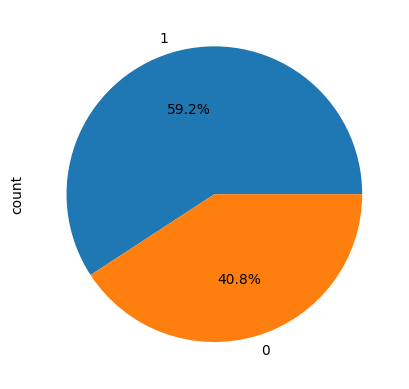

In [12]:
df['Label'].value_counts().plot(kind='pie', autopct='%.1f%%')

In [13]:
yamnet_url = "https://tfhub.dev/google/yamnet/1"
yamnet = hub.load(yamnet_url)

In [14]:
X = df['File Path']
y = df['Label']

In [15]:
def train_validate_test_split(df):
    df = df.sample(frac=1)
    train_end = int(.9 * len(df.index))
    validate_end = int(.05 * len(df.index)) + train_end
    train = df.iloc[:train_end]
    validate = df.iloc[train_end:validate_end]
    test = df.iloc[validate_end:]
    return train, validate, test

df_train, df_validation, df_test = train_validate_test_split(df)
print(len(df_train), len(df_validation), len(df_test))

249 13 15


In [16]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train['File Path'], df_train['Label']))
valid_ds = tf.data.Dataset.from_tensor_slices((df_validation['File Path'], df_validation['Label']))
test_ds = tf.data.Dataset.from_tensor_slices((df_test['File Path'], df_test['Label']))

In [17]:
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    return wav

In [18]:
def wav_map(file_path, label):
    return load_wav_16k_mono(file_path), label

In [19]:
def extract_yamnet_embeddings(wav_data, targets):
    scores, embeddings, spectrogram = yamnet(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings, tf.repeat(targets, num_embeddings))

In [20]:
def process_dataset(dataset):
    return (
        dataset
        .map(wav_map)
        .map(extract_yamnet_embeddings)
        .unbatch()
        .cache()
        .shuffle(1000)
        .batch(32)
        .prefetch(tf.data.AUTOTUNE)
    )

train_ds = process_dataset(train_ds)
valid_ds = process_dataset(valid_ds)
test_ds = process_dataset(test_ds)

In [21]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [22]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [23]:
history = model.fit(train_ds, epochs=50, validation_data=valid_ds, callbacks=[early_stopping])

Epoch 1/50



106/106 [==============================] - 5s 32ms/step - loss: 0.2542 - accuracy: 0.9297 - val_loss: 0.2476 - val_accuracy: 0.9059
Epoch 2/50
106/106 [==============================] - 0s 3ms/step - loss: 0.1316 - accuracy: 0.9584 - val_loss: 0.2734 - val_accuracy: 0.9000
Epoch 3/50
106/106 [==============================] - 0s 3ms/step - loss: 0.1134 - accuracy: 0.9681 - val_loss: 0.2533 - val_accuracy: 0.9118
Epoch 4/50
106/106 [==============================] - 0s 3ms/step - loss: 0.0757 - accuracy: 0.9752 - val_loss: 0.2861 - val_accuracy: 0.9000


In [24]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.254163,0.929711,0.247576,0.905882
1,0.131583,0.958358,0.273403,0.900000
2,0.113370,0.968104,0.253295,0.911765
3,0.075692,0.975192,0.286145,0.900000


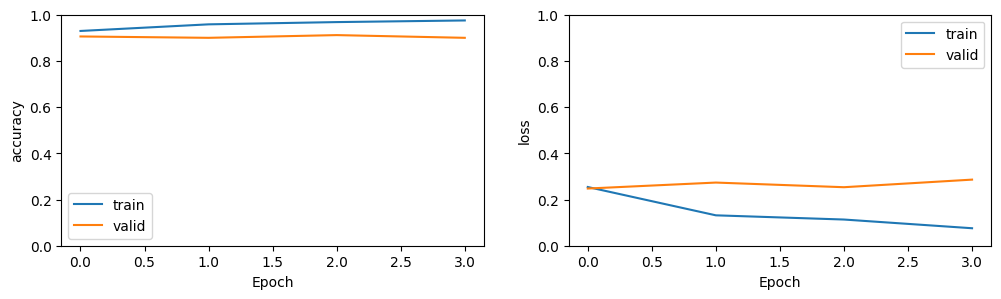

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
ax = axes.ravel()

for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history['val_' + metric])
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(metric)
    ax[i].set_ylim([0, 1])
    ax[i].legend(['train', 'valid'])

plt.show()

In [26]:
results = model.evaluate(test_ds, verbose=0)
print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

Test Loss: 0.4096841812133789
Test Accuracy: 0.8916084170341492


In [27]:
# Assuming you have obtained predictions on the test set
predictions = model.predict(test_ds)

# Convert predictions to class labels (0 or 1) based on maximum probability
predicted_labels = np.argmax(predictions, axis=1)

# Extract the true labels from the test set
true_labels = df_test['Label'].values

# Initialize variables to store class-wise counts and correct predictions
class_counts = {0: 0, 1: 0}
class_correct = {0: 0, 1: 0}

# Calculate class-wise counts and correct predictions
for true_label, predicted_label in zip(true_labels, predicted_labels):
    class_counts[true_label] += 1
    if true_label == predicted_label:
        class_correct[true_label] += 1

# Calculate and display class-wise accuracy
for label, count in class_counts.items():
    accuracy = class_correct[label] / count if count > 0 else 0
    print(f"Accuracy for class {label} (Label {count}): {accuracy}")


9/9 [==============================] - 0s 3ms/step
Accuracy for class 0 (Label 6): 0.3333333333333333
Accuracy for class 1 (Label 9): 0.7777777777777778


In [28]:
# Save the trained model
model.save('cats_dogs_classifier_model')


INFO:tensorflow:Assets written to: cats_dogs_classifier_model\assets


INFO:tensorflow:Assets written to: cats_dogs_classifier_model\assets


In [36]:
# Load the saved model
loaded_model = tf.keras.models.load_model('cats_dogs_classifier_model')

# Define test file paths
test_dir = 'cats_dogs/test/'
test_files = ['cats/cat_3.wav', 'dogs/dog_barking_7.wav']

# Function to process test data and extract YAMNet embeddings
def process_test_data(file_path):
    file_contents = tf.io.read_file(test_dir + file_path)
    wav, _ = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    # You may resample the audio to 16kHz if needed (using other libraries if desired)

    # Extract YAMNet embeddings (similar to your previous function)
    scores, embeddings, spectrogram = yamnet(wav)
    return embeddings

# Load and process test data while extracting YAMNet embeddings
test_embeddings = [process_test_data(file) for file in test_files]

# Stack the embeddings
test_embeddings = tf.concat(test_embeddings, axis=0)

# Predict using the loaded model
predictions = loaded_model.predict(test_embeddings)

# Print predictions
for file_path, prediction in zip(test_files, predictions):
    if prediction[0] > prediction[1]:
        print(f"{file_path}: Prediction - Cat")
    else:
        print(f"{file_path}: Prediction - Dog")


2/2 [==============================] - 0s 118us/step
cats/cat_3.wav: Prediction - Dog
dogs/dog_barking_7.wav: Prediction - Dog
